In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/motorcycle-dataset/BIKE DETAILS.csv


In [2]:
df = pd.read_csv('../input/motorcycle-dataset/BIKE DETAILS.csv')
df.head()

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1061 non-null   object 
 1   selling_price      1061 non-null   int64  
 2   year               1061 non-null   int64  
 3   seller_type        1061 non-null   object 
 4   owner              1061 non-null   object 
 5   km_driven          1061 non-null   int64  
 6   ex_showroom_price  626 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 58.1+ KB


In [4]:
for i in df.select_dtypes(include='object'):
    print(df[i].value_counts(), end='\n'*3)

Bajaj Pulsar 150             41
Royal Enfield Classic 350    27
Honda Activa [2000-2015]     23
Honda CB Hornet 160R         22
Bajaj Pulsar 180             20
                             ..
TVS XL 100 Heavy Duty         1
Suzuki GSX S750               1
TVS Spectra                   1
Yamaha Saluto RX              1
Honda Dream Yuga              1
Name: name, Length: 279, dtype: int64


Individual    1055
Dealer           6
Name: seller_type, dtype: int64


1st owner    924
2nd owner    123
3rd owner     11
4th owner      3
Name: owner, dtype: int64




In [5]:
df.replace({'1st owner':1, '2nd owner':2, '3rd owner':3, '4th owner':4}, inplace=True)
df.rename(columns = {'owner':'prev_owners'}, inplace=True)

In [6]:
current_year = 2020
df['age'] = current_year - df['year']

In [7]:
df.drop(['year','name'], axis=1, inplace=True)

In [8]:
df_2 = df.copy()
new_df = df.dropna().copy()

In [9]:
impute = SimpleImputer(strategy = 'median')

df_2_num = df_2.select_dtypes(exclude='object')
df_2_cat = df_2['seller_type']
x = impute.fit_transform(df_2_num)

In [10]:
df_2 = pd.DataFrame(x, columns=df_2.select_dtypes(exclude='object').columns).copy()

df_2['seller_type'] = df_2_cat

In [11]:
new_df.head()

,selling_price,seller_type,prev_owners,km_driven,ex_showroom_price,age
2,150000,Individual,1,12000,148114.0,2
3,65000,Individual,1,23000,89643.0,5
5,18000,Individual,1,60000,53857.0,10
6,78500,Individual,1,17000,87719.0,2
9,50000,Individual,1,42000,60122.0,4


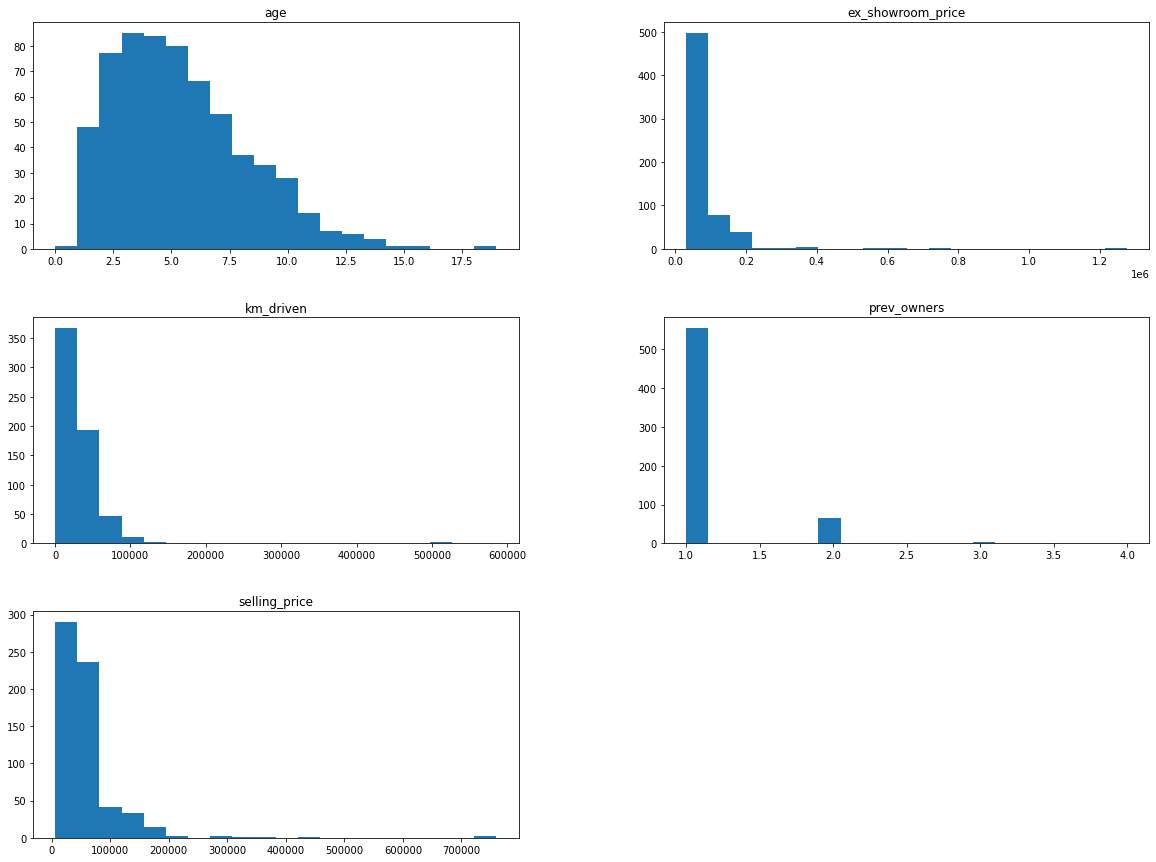

In [12]:
new_df.hist(figsize=(20,15), grid=0, bins=20);

In [13]:
new_df[new_df.selling_price>100000]

,selling_price,seller_type,prev_owners,km_driven,ex_showroom_price,age
2,150000,Individual,1,12000,148114.0,2
13,365000,Individual,1,1127,351680.0,1
18,150000,Individual,1,23000,148114.0,2
19,120000,Individual,1,39000,132680.0,2
37,120000,Individual,1,16000,202310.0,4
...,...,...,...,...,...,...
978,110000,Individual,1,26000,147000.0,3
979,105000,Individual,1,5400,190000.0,5
980,105000,Individual,1,5700,126000.0,2
981,105000,Individual,1,6900,150000.0,7


In [14]:
new_df['price_category'] = pd.cut(new_df['selling_price'], bins=[0,50000,100000,np.inf],labels=[1,2,3])

In [15]:
split = StratifiedShuffleSplit(random_state=42, n_splits=1, test_size=0.25)

for i,j in split.split(new_df, new_df['price_category']):
    new_df_train = new_df.iloc[i]
    new_df_test = new_df.iloc[j]

In [16]:
for i in (new_df_train, new_df_test):
    i.drop('price_category', axis=1, inplace=True)

In [17]:
new_df_train.corr()

,selling_price,prev_owners,km_driven,ex_showroom_price,age
selling_price,1.000000,0.084503,-0.183638,0.920874,-0.324997
prev_owners,0.084503,1.000000,-0.029822,0.164207,0.150631
km_driven,-0.183638,-0.029822,1.000000,-0.121016,0.304220
ex_showroom_price,0.920874,0.164207,-0.121016,1.000000,-0.102869
age,-0.324997,0.150631,0.304220,-0.102869,1.000000


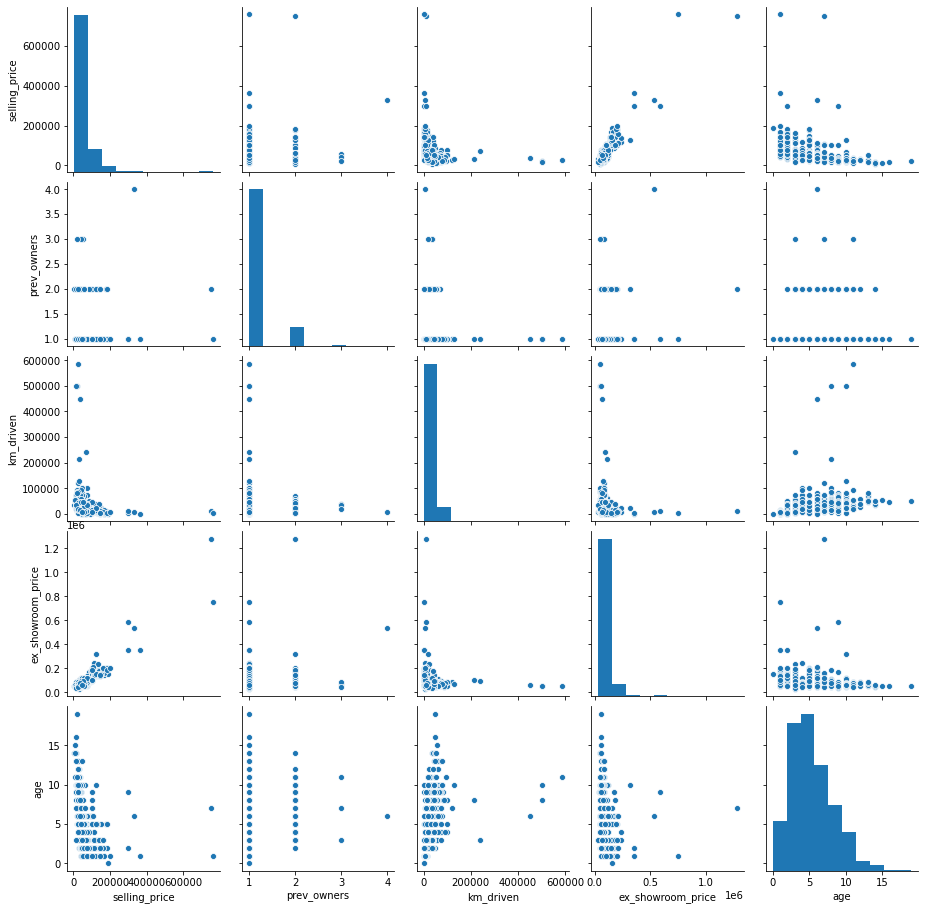

In [18]:
sns.pairplot(new_df_train);

In [19]:
new_df_train_labels = new_df_train['selling_price']
new_df_train.drop('selling_price', axis=1, inplace=True)

In [20]:
num = new_df_train.select_dtypes(exclude='object').columns
cat = new_df_train.select_dtypes(include='object').columns

In [21]:
col_transformer = ColumnTransformer([('num',StandardScaler(), num),('cat', OneHotEncoder(), cat)])
col_transformer

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['prev_owners', 'km_driven', 'ex_showroom_price', 'age'], dtype='object')),
                                ('cat', OneHotEncoder(),
                                 Index(['seller_type'], dtype='object'))])

In [22]:
new_df_train_prepared = col_transformer.fit_transform(new_df_train)
new_df_train_prepared

array([[-0.34544427, -0.41044859,  0.1227951 ,  0.26680467,  0.        ,
         1.        ],
       [-0.34544427, -0.27241154, -0.51149086,  0.59437375,  0.        ,
         1.        ],
       [-0.34544427,  0.31917579, -0.12725525,  0.59437375,  0.        ,
         1.        ],
       ...,
       [-0.34544427, -0.32269647, -0.54374951, -0.3883335 ,  0.        ,
         1.        ],
       [-0.34544427, -0.37100943, -0.16400546,  0.92194283,  0.        ,
         1.        ],
       [-0.34544427, -0.49721473, -0.33368379, -0.71590258,  0.        ,
         1.        ]])

In [23]:
new_df_train_prepared = pd.DataFrame(new_df_train_prepared)
new_df_train_prepared

,0,1,2,3,4,5
0,-0.345444,-0.410449,0.122795,0.266805,0.0,1.0
1,-0.345444,-0.272412,-0.511491,0.594374,0.0,1.0
2,-0.345444,0.319176,-0.127255,0.594374,0.0,1.0
3,-0.345444,9.192986,-0.472007,0.921943,0.0,1.0
4,-0.345444,0.338895,-0.419060,-0.388333,0.0,1.0
...,...,...,...,...,...,...
464,-0.345444,0.220578,0.061769,0.921943,0.0,1.0
465,2.354778,-0.585953,0.655923,-1.043472,0.0,1.0
466,-0.345444,-0.322696,-0.543750,-0.388333,0.0,1.0
467,-0.345444,-0.371009,-0.164005,0.921943,0.0,1.0


In [24]:
new_df_train_prepared.drop(5, axis=1, inplace=True)

In [25]:
lr = LinearRegression()
lr.fit(new_df_train_prepared, new_df_train_labels)

LinearRegression()

In [26]:
def pred_and_score(model, df, labels):
    pred = model.predict(df)
    mse = mean_squared_error(labels, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(labels, pred)
    mae = mean_absolute_error(labels, pred)

    print(f"RMSE: {rmse}\nr2_score: {r2}\nMAE: {mae}")

In [27]:
pred_and_score(lr, new_df_train_prepared, new_df_train_labels)

RMSE: 19600.55310077035
r2_score: 0.9025025725756991
MAE: 11581.863161174902


In [28]:
custom_train = new_df_train_prepared[[1,2,3]].copy()

In [29]:
lr2 = LinearRegression()
lr2.fit(custom_train, new_df_train_labels)

LinearRegression()

In [30]:
pred_and_score(lr2, custom_train, new_df_train_labels)

RMSE: 19689.029861212748
r2_score: 0.9016203805358597
MAE: 11634.396835518251


In [31]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(new_df_train_prepared, new_df_train_labels)

pred_and_score(dt, new_df_train_prepared, new_df_train_labels)

RMSE: 494.10598661905846
r2_score: 0.9999380420935201
MAE: 36.24946695095949


# On test data

In [32]:
x_test = new_df_test.drop('selling_price', axis=1)
y_test = new_df_test['selling_price']

In [33]:
test_prepared = col_transformer.transform(x_test)
test_prepared

array([[-0.34544427, -0.47836281, -0.41929189,  0.26680467,  0.        ,
         1.        ],
       [-0.34544427, -0.23297239,  0.36686484,  0.92194283,  0.        ,
         1.        ],
       [-0.34544427, -0.37889726, -0.42064668, -0.71590258,  0.        ,
         1.        ],
       [-0.34544427, -0.54651367,  0.72224708, -1.04347166,  0.        ,
         1.        ],
       [-0.34544427, -0.38086922, -0.05977204, -0.71590258,  0.        ,
         1.        ],
       [ 2.35477843,  0.31917579, -0.20305027,  0.59437375,  0.        ,
         1.        ],
       [-0.34544427,  0.2205779 , -0.35172325,  0.59437375,  0.        ,
         1.        ],
       [-0.34544427, -0.07521577, -0.10379663, -0.71590258,  0.        ,
         1.        ],
       [-0.34544427,  0.8318848 , -0.372277  ,  0.92194283,  0.        ,
         1.        ],
       [-0.34544427,  0.3980541 , -0.17873728,  0.59437375,  0.        ,
         1.        ],
       [-0.34544427, -0.46960732, -0.19487271,  0.

In [34]:
test_prepared = pd.DataFrame(test_prepared).drop(5, axis=1)

In [35]:
pred_and_score(dt, test_prepared, y_test)

RMSE: 23138.37494101148
r2_score: 0.7868263501082535
MAE: 13466.235668789808


In [36]:
pred_and_score(lr, test_prepared, y_test)

RMSE: 16350.939025334352
r2_score: 0.8935481506551551
MAE: 10479.321730579984
